In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
from datetime import datetime


In [2]:
crime_type_csv_path = "Resources/CrimeType.csv"
crime_csv_path = "Resources/Chicago_Crimes_2012_to_2017.csv"
weather_csv_path = "Resources/ChicagoDailyWeather.csv"

In [3]:
weather_df = pd.read_csv(weather_csv_path)
crimes_df = pd.read_csv(crime_csv_path)
crime_types_df = pd.read_csv(crime_type_csv_path)

In [4]:
# Set Index to 'Primary Type' for lookup
# crime_types_df.set_index(['Primary Type'], inplace=True)
crime_types_df

,Primary Type,Crime Type
0,BATTERY,Violent
1,PUBLIC PEACE VIOLATION,Non-Violent
2,THEFT,Violent
3,WEAPONS VIOLATION,Violent
4,ROBBERY,Violent
5,MOTOR VEHICLE THEFT,Violent
6,ASSAULT,Violent
7,OTHER OFFENSE,Non-Violent
8,DECEPTIVE PRACTICE,Non-Violent
9,CRIMINAL DAMAGE,Violent


In [5]:
# Rename DATE to Date so it matches crime_df for merge
weather_df = weather_df.rename(columns={"DATE": "Date"})

# Convert date string to datetime object
weather_df['Date']=pd.to_datetime(weather_df['Date'], format='%Y/%m/%d')

# Set date ranges for selecting weather for 2012 to 2017
date1 = datetime.strptime('2012-01-01', '%Y-%m-%d')
date2 = datetime.strptime('2017-12-31', '%Y-%m-%d')

# Select weather for 2012 to 2017
weather = weather_df.loc[(weather_df['Date']>=date1) & (weather_df['Date']<=date2)]

# Remove unnecessary fields
complete_weather_df = weather.drop([
    'AWND', 
    'WDF2',
    'STATION',
    'FMTM', 
    'NAME',
    'TAVG',
    'TSUN', 
    'WDF5', 
    'WSF2', 
    'WSF5',
    'WT01',
    'WT02',
    'WT03',
    'WT04',
    'WT05',
    'WT08',
    'WT09',
    'PGTM',
    'PRCP'
], axis = 1)

# Reset index
complete_weather_df.reset_index(inplace=True, drop=True)

complete_weather_df.head()

,Date,TMAX,TMIN
0,2012-01-01,42.0,28.0
1,2012-01-02,28.0,16.0
2,2012-01-03,27.0,10.0
3,2012-01-04,41.0,22.0
4,2012-01-05,49.0,21.0


In [6]:
# Add average weather
complete_weather_df['TAVG'] = (complete_weather_df["TMIN"] + complete_weather_df["TMAX"]) / 2 

# Add day, month and year
complete_weather_df['Day'] = pd.DatetimeIndex(complete_weather_df["Date"]).day
complete_weather_df['Month'] = pd.DatetimeIndex(complete_weather_df["Date"]).month
complete_weather_df['Year'] = pd.DatetimeIndex(complete_weather_df["Date"]).year

complete_weather_df.head()

,Date,TMAX,TMIN,TAVG,Day,Month,Year
0,2012-01-01,42.0,28.0,35.0,1,1,2012
1,2012-01-02,28.0,16.0,22.0,2,1,2012
2,2012-01-03,27.0,10.0,18.5,3,1,2012
3,2012-01-04,41.0,22.0,31.5,4,1,2012
4,2012-01-05,49.0,21.0,35.0,5,1,2012


In [7]:
# Function to categorize temperature (Cold, Mild, Warm, Very Warm, Hot) 
# Below 32 Degrees Fahrenheit : Cold
# 33 to 65 Degrees Fahrenheit: Mild
# 66 to 75 Degrees Fahrenheit: Warm
# 76 to 85 Degrees Fahrenheit: Very Warm
# Above 85 Degrees: Hot
def getTempetureType(row):

    avg_temp = row['TAVG']

    if avg_temp <= 32:
        val = 'Cold'
    elif avg_temp <= 65:
        val = 'Mild'
    elif avg_temp <= 75:
        val = 'Warm'
    elif avg_temp <= 85:
        val = 'Very Warm'
    else:
        val = 'Hot'

    return val

complete_weather_df['Category'] = complete_weather_df.apply(getTempetureType, axis=1)
complete_weather_df.head()

,Date,TMAX,TMIN,TAVG,Day,Month,Year,Category
0,2012-01-01,42.0,28.0,35.0,1,1,2012,Mild
1,2012-01-02,28.0,16.0,22.0,2,1,2012,Cold
2,2012-01-03,27.0,10.0,18.5,3,1,2012,Cold
3,2012-01-04,41.0,22.0,31.5,4,1,2012,Cold
4,2012-01-05,49.0,21.0,35.0,5,1,2012,Mild


In [8]:
# Function to convert month to season
# 3 - 5: Spring
# 6 - 8: Summer
# 9 - 11: Fall
# 1-2; 12: Winter
def getSeasonType(row):

    month = row['Month']

    if month <= 2 or month == 12:
        val = 'Winter'
    elif month >= 3 and month <= 5:
        val = 'Spring'   
    elif month >= 6 and month <= 8:
        val = 'Summer'
    elif month >= 9 and month <= 11:
        val = 'Fall'

    return val

complete_weather_df['Season'] = complete_weather_df.apply(getSeasonType, axis=1)
complete_weather_df.head()

,Date,TMAX,TMIN,TAVG,Day,Month,Year,Category,Season
0,2012-01-01,42.0,28.0,35.0,1,1,2012,Mild,Winter
1,2012-01-02,28.0,16.0,22.0,2,1,2012,Cold,Winter
2,2012-01-03,27.0,10.0,18.5,3,1,2012,Cold,Winter
3,2012-01-04,41.0,22.0,31.5,4,1,2012,Cold,Winter
4,2012-01-05,49.0,21.0,35.0,5,1,2012,Mild,Winter


In [9]:
complete_crime_df = pd.merge(crimes_df, crime_types_df, on="Primary Type", how='inner')

# Remove unnecessary fields
complete_crime_df.drop([
       'Ward', 
       'Community Area', 
       'FBI Code',
       'X Coordinate', 
       'Y Coordinate', 
       'Year', 
       'Updated On', 
       'Latitude',
       'Longitude', 
       'Location', 
       'Unnamed: 0', 
       'ID', 
       'Block', 
       'IUCR', 
       'Beat', 
       'District',
       'Description',
       'Arrest',
       'Domestic',
       'Location Description',
       'Primary Type'
], axis = 1, inplace=True)

complete_crime_df.count()

Case Number    1456713
Date           1456714
Crime Type     1456714
dtype: int64

In [10]:
# Strip out time only
#complete_crime['Time'] = pd.to_datetime(complete_crime['Date']).dt.time

# Convert to datetime
complete_crime_df['Date'] = pd.to_datetime(pd.to_datetime(complete_crime_df['Date']).dt.date)

## Merging 2 Datasets
weather_crime = pd.merge(complete_crime_df, complete_weather_df, on="Date", how = 'inner')
weather_crime.dropna(how = 'any', inplace=True)
weather_crime.count()

Case Number    1452285
Date           1452285
Crime Type     1452285
TMAX           1452285
TMIN           1452285
TAVG           1452285
Day            1452285
Month          1452285
Year           1452285
Category       1452285
Season         1452285
dtype: int64

In [11]:
weather_crime

,Case Number,Date,Crime Type,TMAX,TMIN,TAVG,Day,Month,Year,Category,Season
0,HZ250496,2016-05-03,Violent,67.0,36.0,51.5,3,5,2016,Mild,Spring
1,HZ250409,2016-05-03,Violent,67.0,36.0,51.5,3,5,2016,Mild,Spring
2,HZ250424,2016-05-03,Violent,67.0,36.0,51.5,3,5,2016,Mild,Spring
3,HZ250447,2016-05-03,Violent,67.0,36.0,51.5,3,5,2016,Mild,Spring
4,HZ250489,2016-05-03,Violent,67.0,36.0,51.5,3,5,2016,Mild,Spring
...,...,...,...,...,...,...,...,...,...,...,...
1455816,JA120852,2017-01-18,Violent,36.0,28.0,32.0,18,1,2017,Cold,Winter
1455817,JA120944,2017-01-18,Violent,36.0,28.0,32.0,18,1,2017,Cold,Winter
1455818,JA121043,2017-01-18,Violent,36.0,28.0,32.0,18,1,2017,Cold,Winter
1455819,JA120327,2017-01-18,Non-Violent,36.0,28.0,32.0,18,1,2017,Cold,Winter


In [12]:
# Calculate daily count of crime and average temperatures
daily_group = weather_crime.groupby(['Year', 'Month', 'Day'])
daily_average = daily_group['TAVG'].mean()
daily_crime = daily_group['Date'].count()
daily_crime

Year  Month  Day
2012  1      1      1451
             2       700
             3       805
             4       799
             5       871
                    ... 
2017  1      14      649
             15      600
             16      611
             17      659
             18      655
Name: Date, Length: 1839, dtype: int64

In [13]:
# Calculate monthly count of crime and average temperatures
monthly_group = weather_crime.groupby(['Year', 'Month'])
monthly_average = monthly_group['TAVG'].mean()
monthly_crime = monthly_group['Date'].count()
monthly_crime

Year  Month
2012  1        26194
      2        22953
      3        28533
      4        27164
      5        30067
               ...  
2016  9        23235
      10       23314
      11       21140
      12       19580
2017  1        11357
Name: Date, Length: 61, dtype: int64

In [ ]:
crime_type_group = weather_crime.groupby(['Year'])
crime_type_average = crime_type_group['TAVG'].mean()
crime_type_crime = crime_type_group['Date'].count()
crime_type_crime

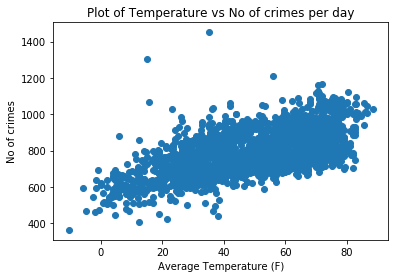

In [14]:
fig = plt.figure()
ax = plt.axes()

ax.set_title('Plot of Temperature vs No of crimes per day')
ax.set_xlabel('Average Temperature (F)')
ax.set_ylabel('No of crimes')
plt.scatter(daily_average.values, daily_crime.values)
plt.show()

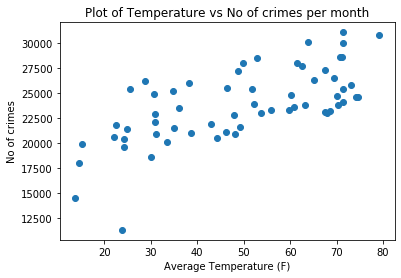

In [15]:
fig = plt.figure()
ax = plt.axes()

ax.set_title('Plot of Temperature vs No of crimes per month')
ax.set_xlabel('Average Temperature (F)')
ax.set_ylabel('No of crimes')
plt.scatter(monthly_average.values, monthly_crime.values)
plt.show()
 

In [ ]:
fig = plt.figure()
ax = plt.axes()

ax.set_title('Plot of Temperature vs No of crimes per month')
ax.set_xlabel('Average Temperature (F)')
ax.set_ylabel('No of crimes')
plt.scatter(crime_type_average.values, crime_type_crime.values)
plt.show()

In [ ]:
# def getCrimeType(row):

#     violent_crimes = [
#         'CRIM SEXUAL ASSAULT', 
#         'THEFT', 
#         'ROBBERY', 
#         'BATTERY',  
#         'WEAPONS VIOLATION',
#         'OFFENSE INVOLVING CHILDREN',
#         'CRIMINAL DAMAGE', 
#         'ASSAULT',
#         'MOTOR VEHICLE THEFT',
#         'ARSON', 
#         'PUBLIC PEACE VIOLATION',
#         'SEX OFFENSE', 
#         'KIDNAPPING', 
#         'INTIMIDATION', 
#         'HUMAN TRAFFICKING', 
#         'HOMICIDE'
#     ]

#     non_violent_crimes = [
#         'DECEPTIVE PRACTICE', 
#         'BURGLARY', 
#         'OTHER OFFENSE', 
#         'NARCOTICS', 
#         'CRIMINAL TRESPASS',
#         'OBSCENITY', 
#         'LIQUOR LAW VIOLATION', 
#         'PROSTITUTION', 
#         'NON - CRIMINAL', 
#         'INTERFERENCE WITH PUBLIC OFFICER',
#         'GAMBLING', 
#         'PUBLIC INDECENCY', 
#         'STALKING', 
#         'OTHER NARCOTIC VIOLATION', 
#         'CONCEALED CARRY LICENSE VIOLATION',
#         'NON-CRIMINAL', 
#         'NON-CRIMINAL (SUBJECT SPECIFIED)'
#     ]

#     primary_type = row['Primary Type']

#     if primary_type in violent_crimes:
#         return "Violent"
#     elif primary_type in non_violent_crimes:
#         return "Non-Violent"
#     else:
#         return "Unknown"
        

# complete_crime_df['Crime Type'] = complete_crime_df.apply(getCrimeType, axis=1)

# complete_crime_df['Crime Type'].unique()

In [ ]:
#get the daily avg temp
avg_daily = weather_crime.loc[:,["Date", "TMAX", "TMIN"]]
maxtemp = weather_crime["TMAX"]
mintemp = weather_crime["TMIN"]
total_avg = maxtemp + mintemp / 2
avg_daily['Daily Average Temp'] = total_avg 
avg_daily.head()

In [ ]:
#4 Categories (Fall, Winter, Spring, Summer) 
#Fall: 09 to 11 
#Winter: 11 to 3
#Spring: 3 to 5
#Summer: 06 to 8


#adding year and month to average daily weather dataframe to create the season by month dataframe
season_df = avg_daily.loc[:,["Date", "TMAX","TMIN","Daily Average Temp","Category"]]


season_df.head()

In [ ]:
#create function to filter through data




In [ ]:
#apply function & create new column for the return values

season_df['Season'] = season_df.apply(I, axis=1)
season_df.head()